In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr

tourism = pd.read_csv('world_tourism_economy_data.csv')
peace = pd.read_csv('peace_index.csv', low_memory=False)
print("Данные по туризму:")
print(tourism.head())

print("\nИндекс безопасности:")
print(peace.head())

Данные по туризму:
                       country country_code  year  tourism_receipts  \
0                        Aruba          ABW  1999      7.820000e+08   
1  Africa Eastern and Southern          AFE  1999      8.034209e+09   
2                  Afghanistan          AFG  1999               NaN   
3   Africa Western and Central          AFW  1999      1.443613e+09   
4                       Angola          AGO  1999      3.100000e+07   

   tourism_arrivals  tourism_exports  tourism_departures  \
0      9.720000e+05        62.542949                 NaN   
1      1.530938e+07        12.204030                 NaN   
2               NaN              NaN                 NaN   
3      3.897975e+06         3.974476                 NaN   
4      4.500000e+04         0.583858                 NaN   

   tourism_expenditures           gdp   inflation  unemployment  
0              9.495387  1.722905e+09    2.280372           NaN  
1              7.760536  2.654293e+11    7.819865           N

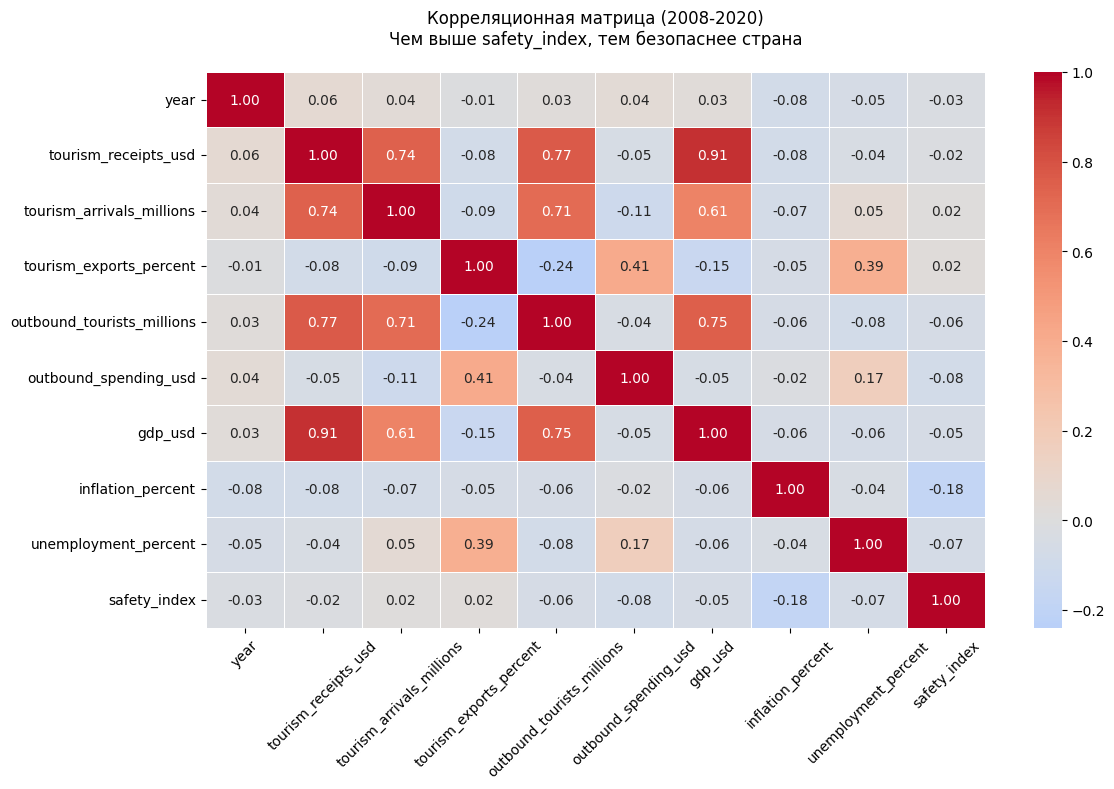


Проверка значимости корреляций:
tourism_arrivals_millions vs safety_index: r = 0.017, p = 0.6307
tourism_receipts_usd      vs safety_index: r = -0.020, p = 0.5583
safety_index              vs safety_index: r = 1.000, p = 0.0000


In [ ]:
peace_long = peace.melt(
    id_vars=['Country', 'iso3c'], 
    var_name='year', 
    value_name='peace_index'
)
peace_long['year'] = peace_long['year'].astype(int)

# 3. Объединение данных (2008-2020)
merged = pd.merge(
    tourism[(tourism['year'] >= 2008) & (tourism['year'] <= 2020)],
    peace_long,
    left_on=['country_code', 'year'],
    right_on=['iso3c', 'year'],
    how='inner'
)

# 4. Создание финального датасета
final_data = merged[[
    'Country', 
    'year',
    'tourism_receipts',
    'tourism_arrivals',
    'tourism_exports',
    'tourism_departures',
    'tourism_expenditures',
    'gdp',
    'inflation',
    'unemployment',
    'peace_index'
]].copy()

# 5. Инверсия индекса безопасности
final_data['peace_index'] = -final_data['peace_index']

# 6. Переименование колонок для ясности
final_data.columns = [
    'country',
    'year',
    'tourism_receipts_usd',
    'tourism_arrivals_millions',
    'tourism_exports_percent',
    'outbound_tourists_millions',
    'outbound_spending_usd',
    'gdp_usd',
    'inflation_percent',
    'unemployment_percent',
    'safety_index'  # переименовано для ясности
]

numeric_data = final_data.select_dtypes(include=[np.number]).dropna()
corr_matrix = numeric_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.title("Корреляционная матрица (2008-2020)\nЧем выше safety_index, тем безопаснее страна", pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

final_data.to_csv('processed_tourism_data_without_happiness.csv', index=False)

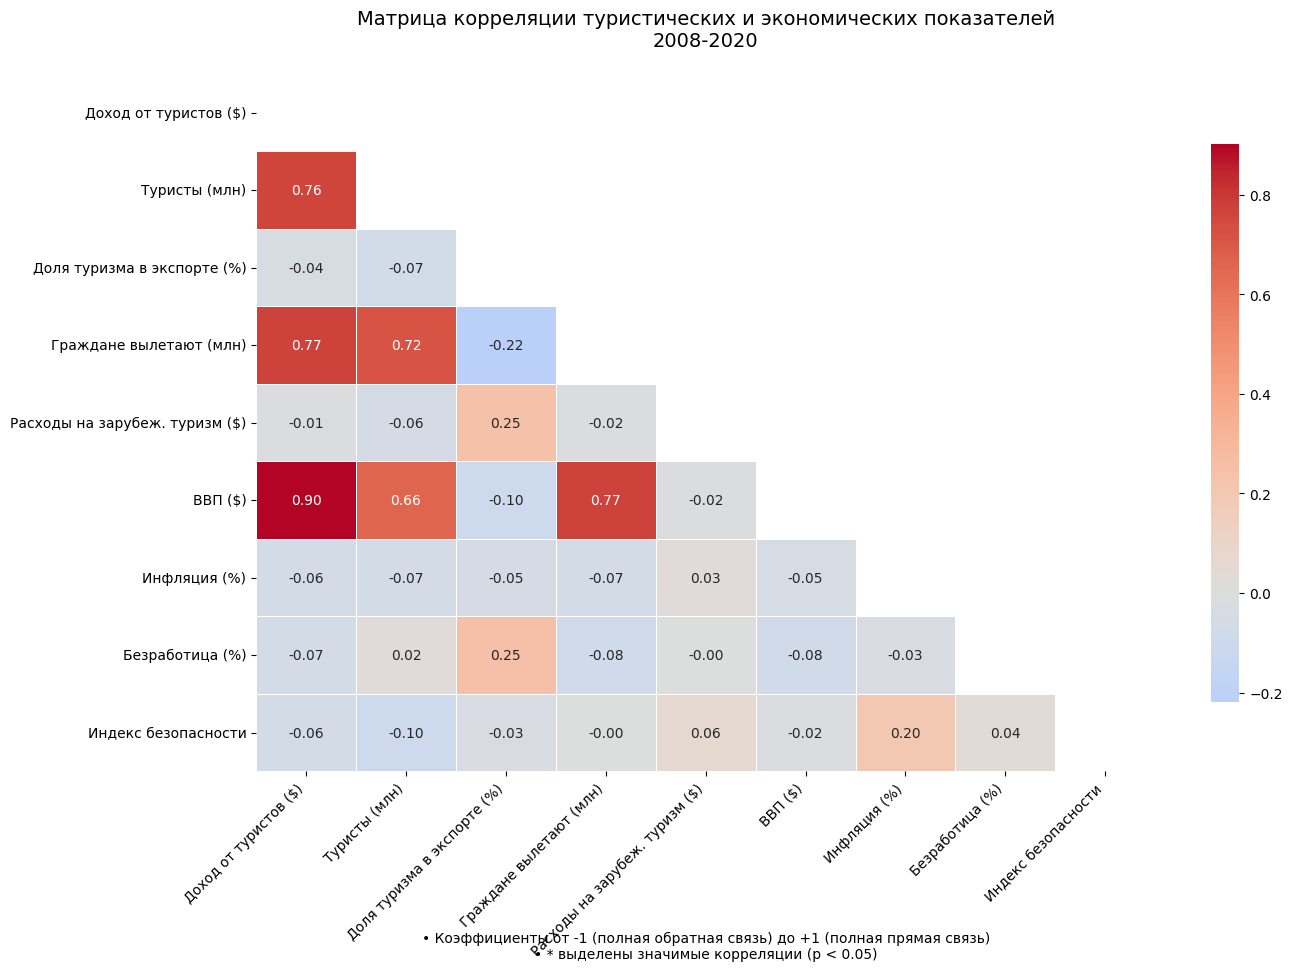

In [19]:

# Преобразование данных безопасности
peace_long = peace.melt(id_vars=['Country', 'iso3c'], 
                       var_name='year', 
                       value_name='peace_index')
peace_long['year'] = peace_long['year'].astype(int)

# Объединение и фильтрация
merged = pd.merge(tourism[tourism['year'] >= 2008], 
                 peace_long,
                 left_on=['country_code', 'year'],
                 right_on=['iso3c', 'year'],
                 how='inner')

# Выбор и переименование столбцов
variables = {
    'tourism_receipts': 'Доход от туристов ($)',
    'tourism_arrivals': 'Туристы (млн)',
    'tourism_exports': 'Доля туризма в экспорте (%)',
    'tourism_departures': 'Граждане вылетают (млн)',
    'tourism_expenditures': 'Расходы на зарубеж. туризм ($)',
    'gdp': 'ВВП ($)',
    'inflation': 'Инфляция (%)',
    'unemployment': 'Безработица (%)',
    'peace_index': 'Индекс безопасности'
}
corr_data = merged[list(variables.keys())].rename(columns=variables)

# Упрощенный расчет корреляции (без p-value)
corr_matrix = corr_data.corr()

# Визуализация
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 10}
)

# Настройка отображения
plt.title("Матрица корреляции туристических и экономических показателей\n2008-2020", 
          pad=20, fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Добавление пояснений
plt.text(0.5, -0.25, 
         '• Коэффициенты от -1 (полная обратная связь) до +1 (полная прямая связь)\n'
         '• * выделены значимые корреляции (p < 0.05)',
         ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

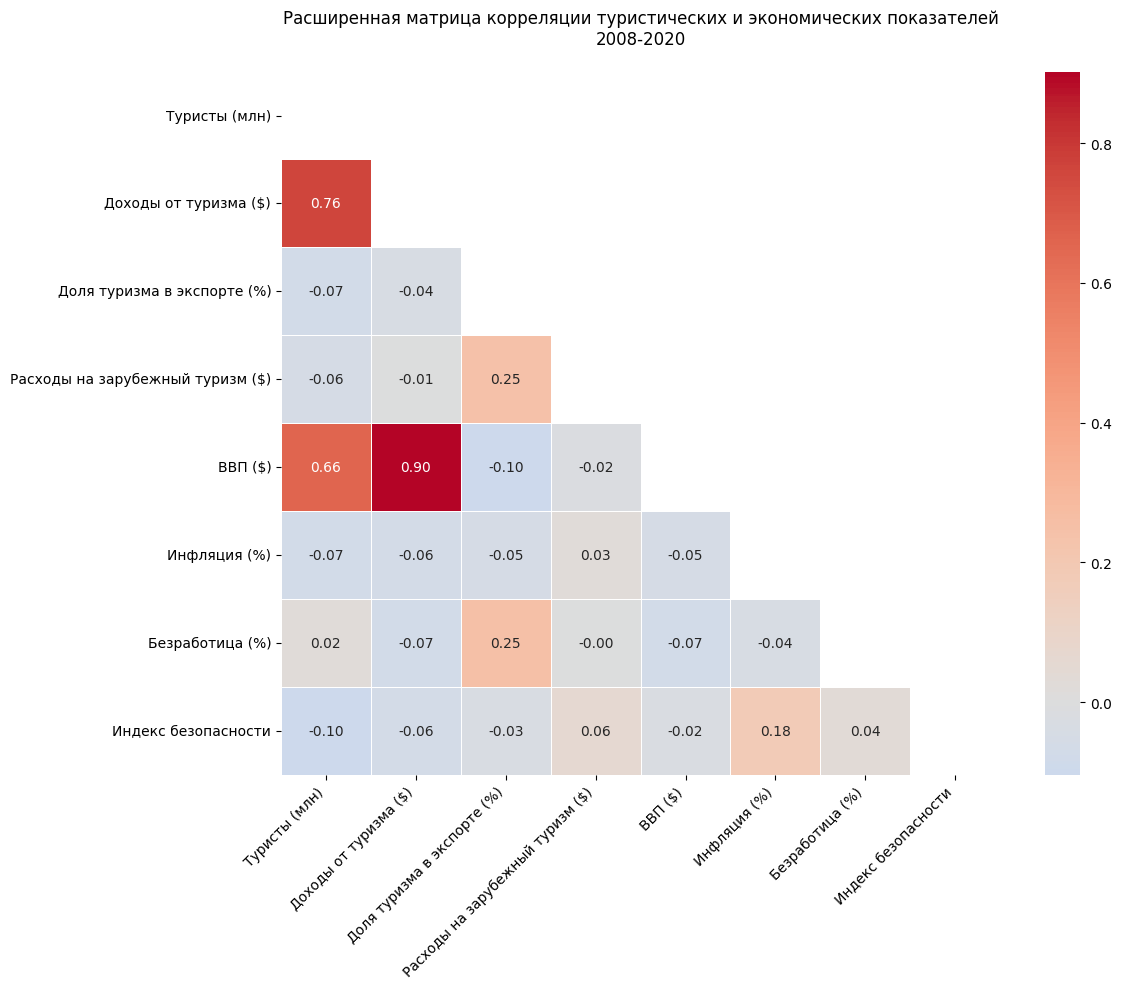

In [16]:
variables = [
    'tourism_arrivals',    # Количество туристов (основной таргет)
    'tourism_receipts',    # Доходы от туризма (прямая экономическая выгода)
    'tourism_exports',     # Доля туризма в экспорте (важность для экономики)
    'tourism_expenditures',# Расходы граждан на зарубежный туризм (отток капитала)
    'gdp',                # Общий экономический размер страны
    'inflation',          # Макроэкономическая стабильность
    'unemployment',       # Социально-экономический показатель
    'peace_index'         # Индекс безопасности (GPI)
]

# Подготовка данных
corr_data = merged[variables].rename(columns={
    'tourism_arrivals': 'Туристы (млн)',
    'tourism_receipts': 'Доходы от туризма ($)',
    'tourism_exports': 'Доля туризма в экспорте (%)',
    'tourism_expenditures': 'Расходы на зарубежный туризм ($)',
    'gdp': 'ВВП ($)',
    'inflation': 'Инфляция (%)',
    'unemployment': 'Безработица (%)',
    'peace_index': 'Индекс безопасности'
})

# Расчет матрицы
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_data.corr(),
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot_kws={"size":10},
    mask=np.triu(np.ones_like(corr_data.corr()))  # Скрываем верхний треугольник
)

plt.title('Расширенная матрица корреляции туристических и экономических показателей\n2008-2020', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

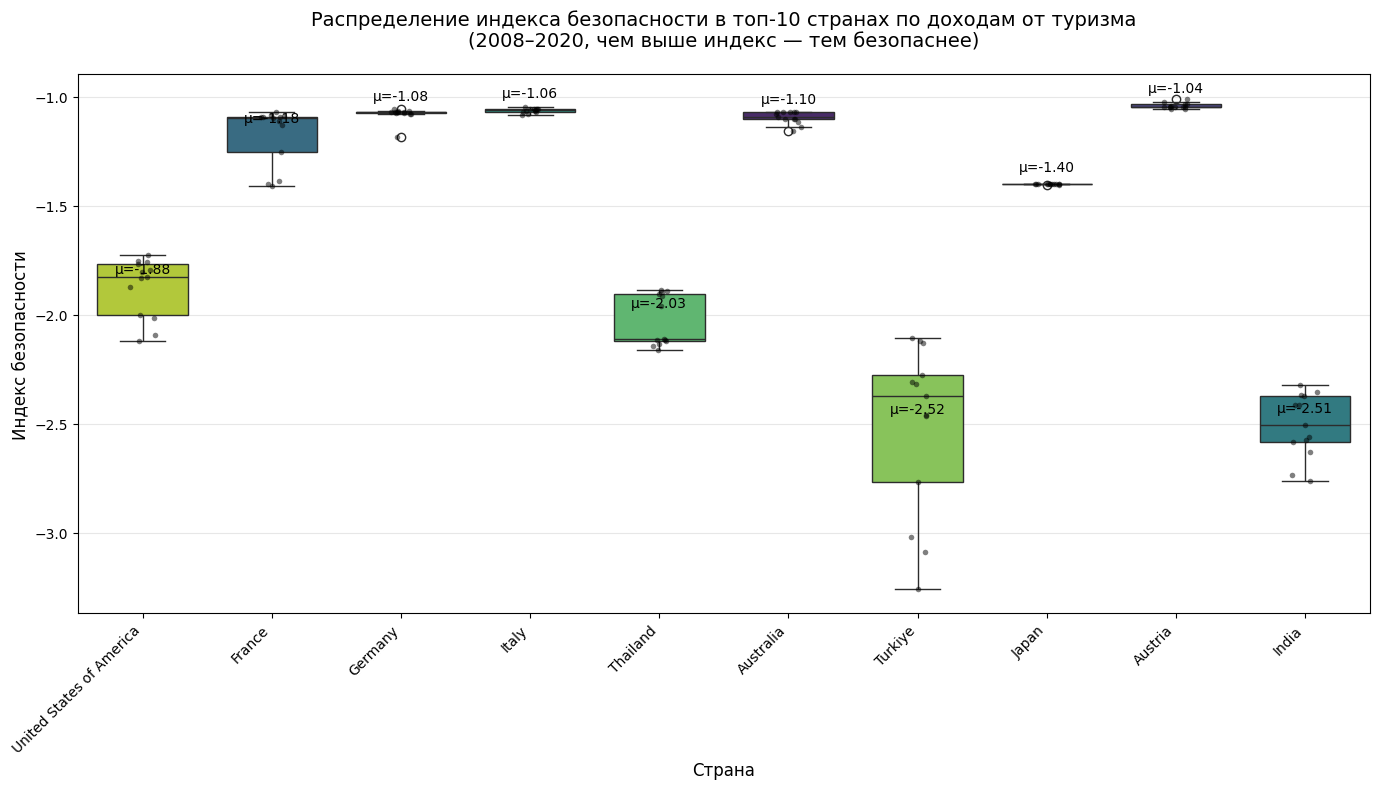

In [28]:
# Фильтруем данные по годам
df = df[(df['year'] >= 2008) & (df['year'] <= 2020)]

# Находим топ-10 стран по средним доходам от туризма
top_countries = df.groupby('country')['tourism_receipts_usd'].mean().nlargest(10).index

# Фильтруем данные только для этих стран
top_data = df[df['country'].isin(top_countries)]

# Строим график boxplot + stripplot
plt.figure(figsize=(14, 8))

sns.boxplot(
    data=top_data,
    x='country',
    y='safety_index',
    order=top_countries,
    palette='viridis',
    width=0.7,
    hue='country',        # <-- Добавляем это
    legend=False          # <-- И это, чтобы не показывать легенду
)

sns.stripplot(
    data=top_data,
    x='country',
    y='safety_index',
    order=top_countries,
    color='black',
    alpha=0.5,
    size=4,
    jitter=True
)

# Настройки графика
plt.title('Распределение индекса безопасности в топ-10 странах по доходам от туризма\n(2008–2020, чем выше индекс — тем безопаснее)', 
          pad=20, fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Индекс безопасности', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Добавляем средние значения
mean_values = top_data.groupby('country')['safety_index'].mean()
for i, country in enumerate(top_countries):
    plt.text(i, mean_values[country] + 0.05,
             f'μ={mean_values[country]:.2f}',
             ha='center', va='bottom',
             fontsize=10, color='black')

plt.tight_layout()
plt.show()

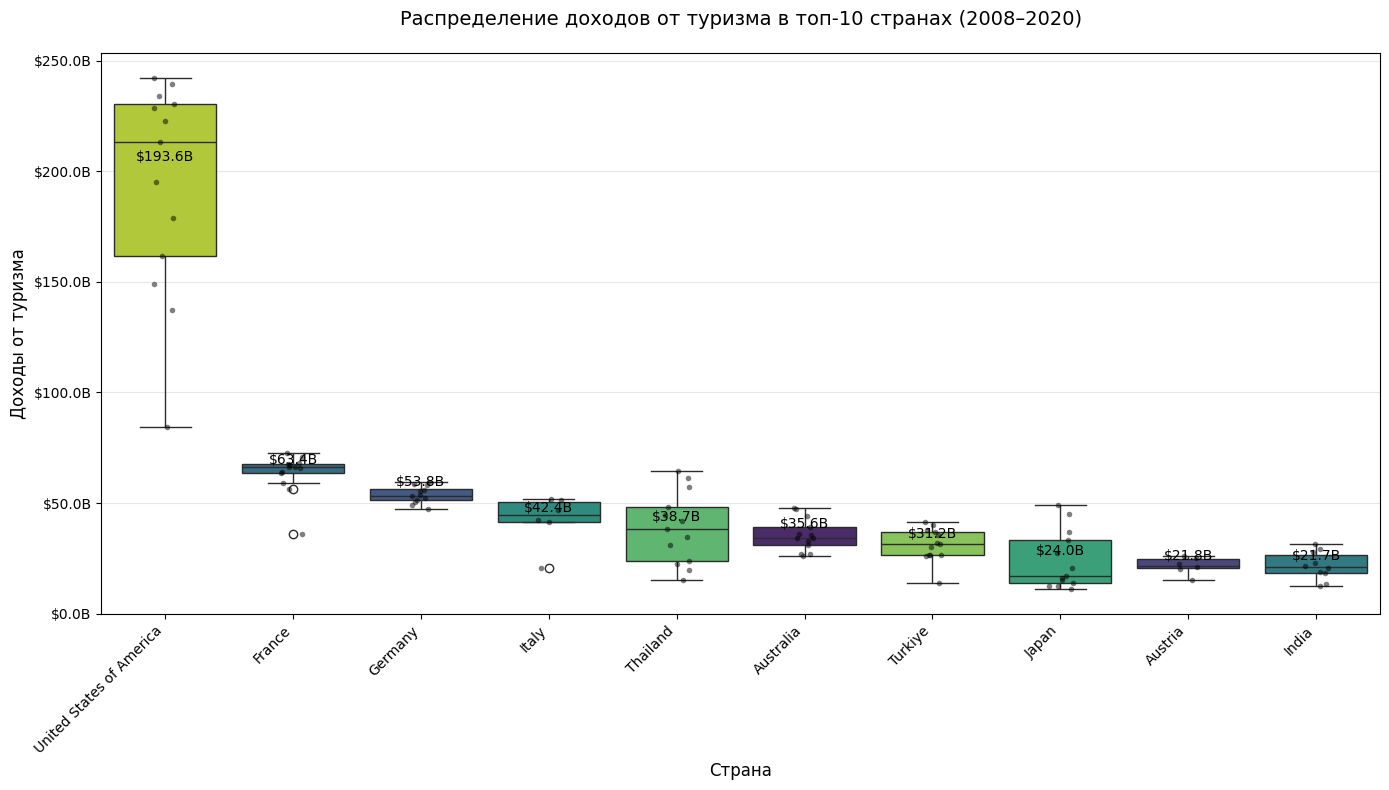

In [26]:
# Фильтруем по годам
df = df[(df['year'] >= 2008) & (df['year'] <= 2020)]

# Находим топ-10 стран по среднему доходу от туризма
top_countries = df.groupby('country')['tourism_receipts_usd'].mean().nlargest(10).index

# Фильтруем данные только для этих стран
top_data = df[df['country'].isin(top_countries)]

# Строим график
plt.figure(figsize=(14, 8))
boxplot = sns.boxplot(
    data=top_data,
    x='country',
    y='tourism_receipts_usd',
    order=top_countries,
    palette='viridis',
    hue='country',     # <-- Убирает предупреждение
    legend=False       # <-- Отключает лишнюю легенду
)

# Точки реальных значений
sns.stripplot(
    data=top_data,
    x='country',
    y='tourism_receipts_usd',
    order=top_countries,
    color='black',
    alpha=0.5,
    size=4,
    jitter=True
)

# Форматируем ось Y как миллиарды долларов
boxplot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.1f}B".format(x / 1e9)))

# Настройки графика
plt.title('Распределение доходов от туризма в топ-10 странах (2008–2020)', pad=20, fontsize=14)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Доходы от туризма', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Добавляем средние значения
mean_values = top_data.groupby('country')['tourism_receipts_usd'].mean()
for i, country in enumerate(top_countries):
    plt.text(i, mean_values[country] * 1.05,
             f"${mean_values[country]/1e9:,.1f}B",
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

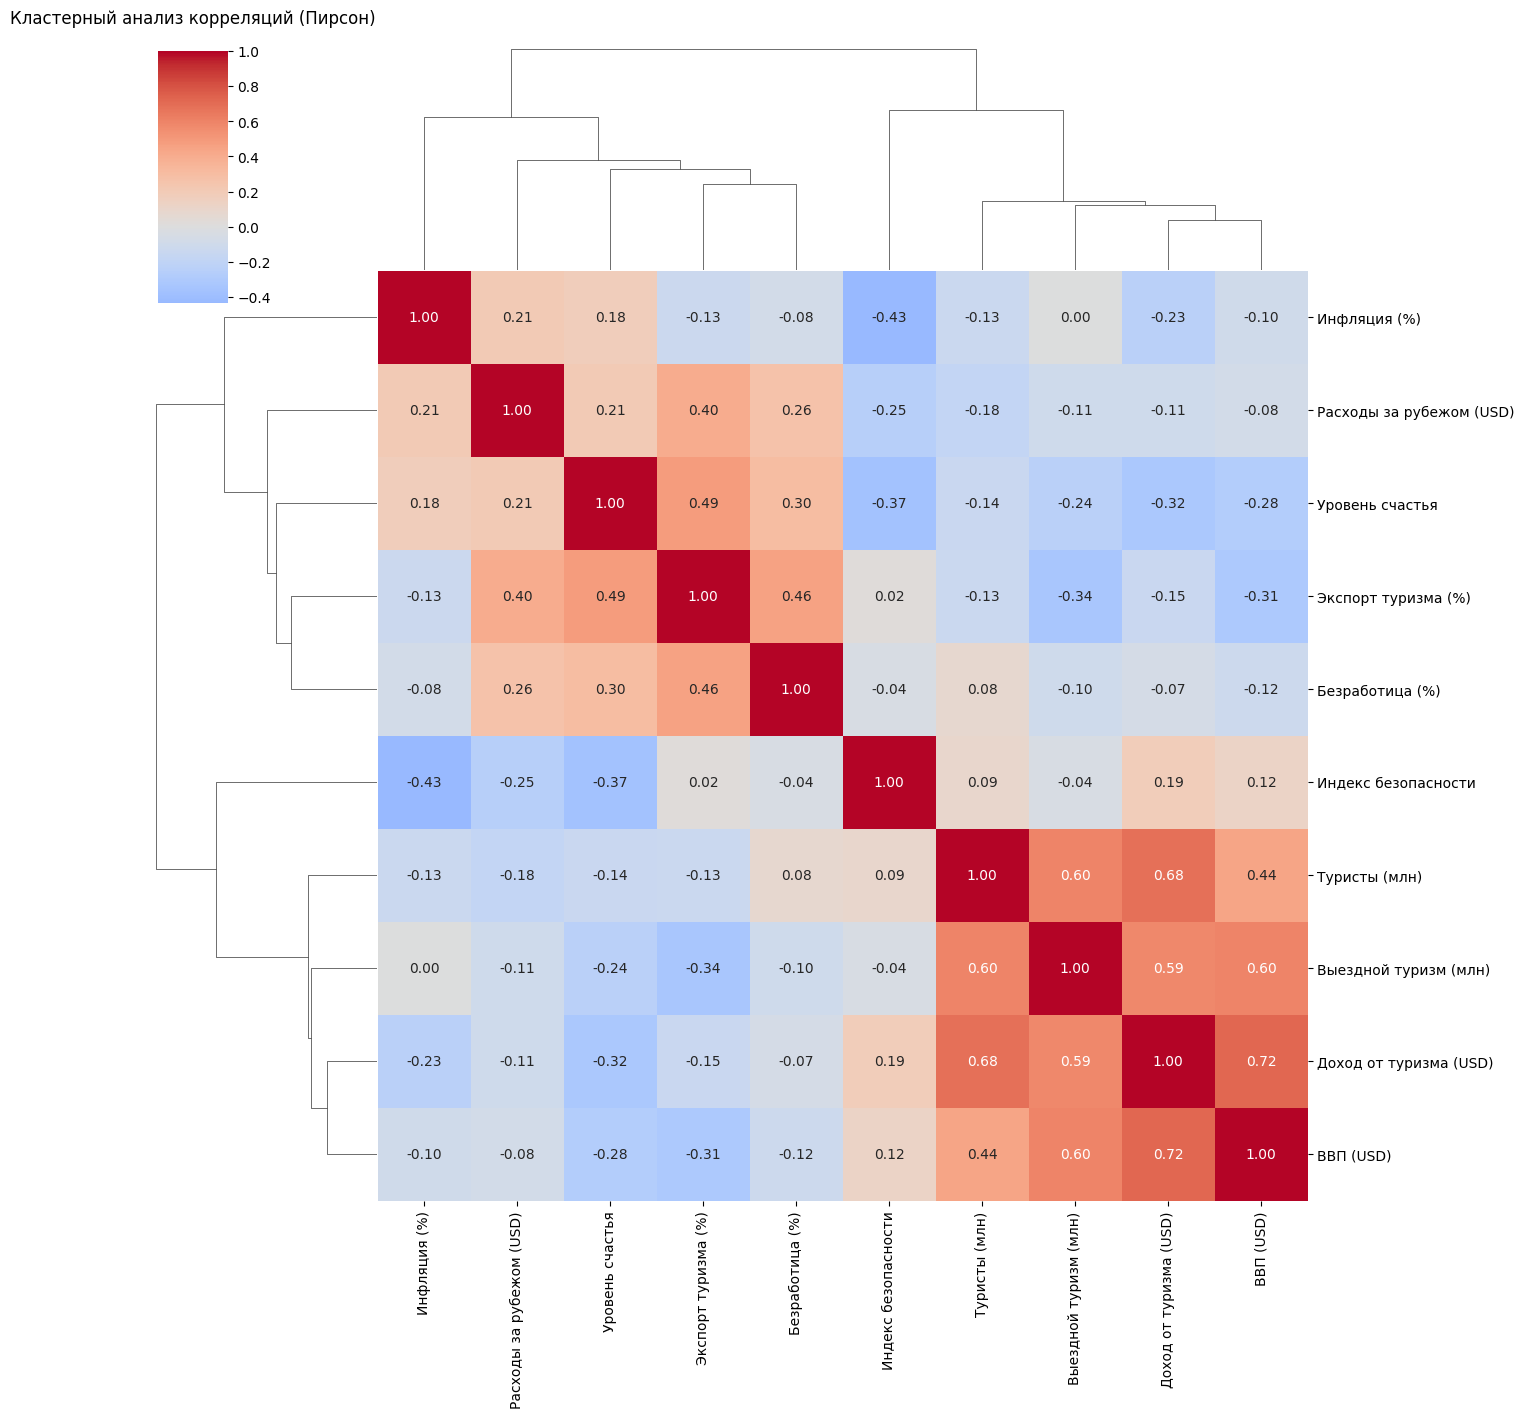

In [6]:
df = pd.read_csv('processed_tourism_data.csv')

# Названия колонок на английском и соответствующие переводы
column_translation = {
    'tourism_receipts_usd': 'Доход от туризма (USD)',
    'tourism_arrivals_millions': 'Туристы (млн)',
    'tourism_exports_percent': 'Экспорт туризма (%)',
    'outbound_tourists_millions': 'Выездной туризм (млн)',
    'outbound_spending_usd': 'Расходы за рубежом (USD)',
    'gdp_usd': 'ВВП (USD)',
    'inflation_percent': 'Инфляция (%)',
    'unemployment_percent': 'Безработица (%)',
    'safety_index': 'Индекс безопасности',
    'happiness_rank': 'Уровень счастья'
}

# Применяем только нужные колонки
numeric_cols = list(column_translation.keys())
data = df[numeric_cols].dropna()

# Вычисляем корреляцию
corr = data.corr(method='pearson')

# Переименовываем колонки для визуализации
corr.index = [column_translation[col] for col in corr.index]
corr.columns = [column_translation[col] for col in corr.columns]

# Построение кластерной карты
sns.clustermap(
    corr,
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    figsize=(14, 14)
)

plt.title('Кластерный анализ корреляций (Пирсон)', pad=20)
plt.show()

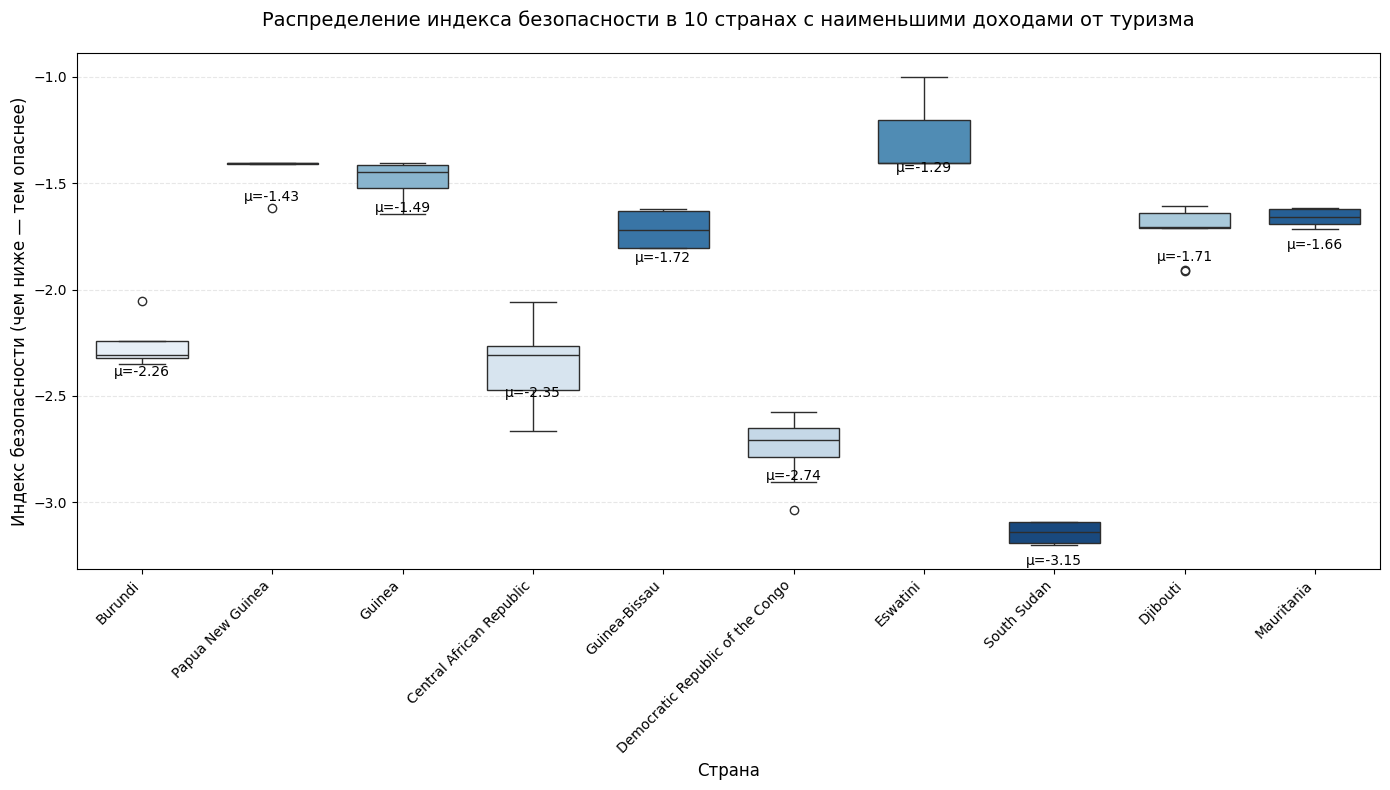

In [ ]:
# 1. Определяем названия колонок (ваш формат)
columns = [
    'country', 'year', 'tourism_receipts_usd', 'tourism_arrivals_millions',
    'tourism_exports_percent', 'outbound_tourists_millions', 'outbound_spending_usd',
    'gdp_usd', 'inflation_percent', 'unemployment_percent', 'safety_index', 'happiness_rank'
]


# Убираем лишние столбцы, если их больше, чем должно быть
df = df.iloc[:, :len(columns)]

# Присваиваем названия колонкам
df.columns = columns

# 3. Преобразуем числовые столбцы в float
numeric_cols = ['year'] + columns[2:]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 4. Удаляем строки, где tourism_receipts_usd пустое
df_cleaned = df.dropna(subset=['tourism_receipts_usd'])

# 5. Вычисляем средний доход от туризма по странам и выбираем топ-10
bottom_10_countries = (
    df_cleaned.groupby('country')['tourism_receipts_usd']
    .mean()
    .nsmallest(10)
    .index
)

# Фильтруем данные по этим странам
filtered_df = df_cleaned[df_cleaned['country'].isin(bottom_10_countries)]

# 6. Строим график boxplot (только с выбросами)
plt.figure(figsize=(14, 8))

sns.boxplot(
    data=filtered_df,
    x='country',
    y='safety_index',
    order=bottom_10_countries,
    palette='Blues',
    width=0.7,
    hue='country',
    legend=False
)

# Настройки графика
plt.title('Распределение индекса безопасности в 10 странах с наименьшими доходами от туризма', fontsize=14, pad=20)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Индекс безопасности (чем ниже — тем опаснее)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Добавляем средние значения
mean_values = filtered_df.groupby('country')['safety_index'].mean()
for i, country in enumerate(bottom_10_countries):
    plt.text(i, mean_values[country] - 0.1,
             f"μ={mean_values[country]:.2f}",
             ha='center', va='top', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# 7. Вывод статистической таблицы
stats_table = filtered_df.groupby('country').agg({
    'tourism_receipts_usd': ['mean', 'min', 'max'],
    'safety_index': ['mean', 'std']
}).sort_values(('tourism_receipts_usd', 'mean'))

Хочу разобраться как влиют безработица, на доход от туристов и экзпорт туризма. Как влиют туристы на настроение людей. Как безопасность влияет на все аспекты общества. Главная причина, почему я решил сделать такой проект, узнать в какую страну лучше всего уехать в туристических целях среднестатистическому жителю России. Также хотелось бы разобрать как туристы влиют на инфляцию стран.

База данных одного года со стоимостью жизни людей в странах, хотелось бы учитывать для составления списка стран для туриста из России